# RNN Testing

## 1. Imports

In [1]:
import argparse
import os
import json
from typing import Optional, List
import numpy as np
import tensorflow as tf # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from sklearn.metrics import f1_score

from train import (
    run_training_pipeline,
    load_and_preprocess_data_for_testing,
    MODEL_DIR,
)

from rnn import (
    SequentialFromScratch,
    SimpleRNNLayerNP,
    BidirectionalWrapperNP,
    DropoutLayerNP,
    DenseLayerNP,
    EmbeddingLayerNP,
    d_cross_entropy_softmax_np
)

## 2. Configuration Constants

In [2]:

MAX_FEATURES = 20000 
SEQUENCE_LENGTH = 150 
EMBEDDING_DIM = 256
MAIN_NUM_CLASSES = 3

print(f"Using MODEL_DIR: {MODEL_DIR}")

Using MODEL_DIR: models


## 3. Helper Function: Load Keras Model and Vectorizer

In [3]:
def load_keras_model_and_vectorizer(model_config_name: str):
    if model_config_name == "best_model":
        keras_model_filename = "best_model.keras"
    else:
        keras_model_filename = f"model_{model_config_name}.keras"
    
    keras_model_path_full = os.path.join(MODEL_DIR, keras_model_filename)

    if not os.path.exists(keras_model_path_full):
        print(f"Error: Keras model not found for '{model_config_name}'.")
        print(f"Expected Keras model: {keras_model_path_full}")
        if model_config_name != "best_model":
            print("Please ensure --train has been run for this configuration and the name is correct.")
        else:
            print("Please ensure --train has been run to generate 'best_model.keras'.")
        return None, None
        
    print(f"Loading Keras model from: {keras_model_path_full}")
    try:
        keras_model = load_model(keras_model_path_full, compile=False) 
    except Exception as e:
        print(f"Error loading Keras model: {e}")
        return None, None

    retrieved_keras_vectorizer = None
    if keras_model.layers and isinstance(keras_model.layers[0], tf.keras.layers.TextVectorization):
        retrieved_keras_vectorizer = keras_model.layers[0]
        print("TextVectorization layer successfully retrieved from the loaded Keras model.")
    else:
        print("Error: First layer of loaded Keras model is not TextVectorization or model has no layers.")
        print("The --test-scratch functionality relies on the Keras model containing the TextVectorization layer.")
        return None, None 

    return keras_model, retrieved_keras_vectorizer

## 4. Core Logic: Run From-Scratch Test

In [4]:
def run_test_scratch(model_config_name: str, inference_batch_size: Optional[int] = None, demo_backward_pass: bool = False):
    print(f"\n--- Running From-Scratch Test for model: {model_config_name} ---")
    if inference_batch_size is not None:
        print(f"--- Using inference batch size for scratch model: {inference_batch_size} ---")

    keras_model, text_vectorizer_keras = load_keras_model_and_vectorizer(model_config_name)
    if keras_model is None or text_vectorizer_keras is None:
        print("Failed to load Keras model or retrieve its vectorizer. Aborting scratch test.")
        return

    num_classes_runtime = keras_model.layers[-1].units
    print(f"Number of classes detected from Keras model's last layer: {num_classes_runtime}")

    loaded_data = load_and_preprocess_data_for_testing(for_scratch_test=True)
    if loaded_data is None or loaded_data[4] is None or loaded_data[5] is None: 
        print("Failed to load test data. Ensure data/test.csv exists and is valid.")
        return
    test_texts = loaded_data[4] 
    test_labels_raw = loaded_data[5]

    print("Vectorizing test texts using the Keras model's TextVectorization layer...")
    try:
        vectorized_test_data_tf = text_vectorizer_keras(tf.constant(test_texts, dtype=tf.string))
    except Exception as e:
        print(f"Error during TextVectorization of test_texts: {e}")
        return
        
    vectorized_test_data_np = vectorized_test_data_tf.numpy()
    print(f"Shape of vectorized test data (NumPy): {vectorized_test_data_np.shape}")

    num_rnn_layers_cfg: int
    rnn_units_cfg: int
    direction_cfg: str
    
    if model_config_name == "best_model":
        best_model_config_path = os.path.join(MODEL_DIR, "best_model_config.json")
        if not os.path.exists(best_model_config_path):
            print(f"Error: 'best_model_config.json' not found at {best_model_config_path}.")
            print("This file is needed to determine the architecture of 'best_model.keras' for the scratch model.")
            print("Please ensure --train has been run and a best model (with its config) was saved.")
            return
        try:
            with open(best_model_config_path, 'r') as f:
                config_data = json.load(f)
            num_rnn_layers_cfg = int(config_data['num_rnn_layers'])
            rnn_units_cfg = int(config_data['rnn_units'])
            direction_cfg = config_data['rnn_direction']
            if direction_cfg not in ['unidirectional', 'bidirectional']:
                raise ValueError(f"Invalid direction '{direction_cfg}' in '{best_model_config_path}'.")
            print(f"Loaded configuration for 'best_model' from JSON: Layers={num_rnn_layers_cfg}, Units={rnn_units_cfg}, Direction={direction_cfg}")
        except Exception as e:
            print(f"Error loading or parsing '{best_model_config_path}': {e}")
            return
    else:
        parts = model_config_name.split('_')
        try:
            num_rnn_layers_cfg = int(parts[parts.index('layers') + 1])
            rnn_units_cfg = int(parts[parts.index('units') + 1])
            direction_cfg = parts[parts.index('dir') + 1]
            if direction_cfg not in ['unidirectional', 'bidirectional']:
                raise ValueError(f"Invalid direction '{direction_cfg}' in model configuration name.")
        except (ValueError, IndexError) as e:
            print(f"Error parsing model configuration from name '{model_config_name}': {e}")
            return
        
    is_bidirectional_cfg = (direction_cfg == 'bidirectional')

    scratch_layers = []
    current_keras_layer_idx = 0 

    if isinstance(keras_model.layers[current_keras_layer_idx], tf.keras.layers.TextVectorization):
        current_keras_layer_idx += 1
    else:
        raise ValueError("Keras model's first layer is not TextVectorization. Inconsistency.")

    if current_keras_layer_idx < len(keras_model.layers) and \
       isinstance(keras_model.layers[current_keras_layer_idx], tf.keras.layers.Embedding):
        keras_embedding_layer = keras_model.layers[current_keras_layer_idx]
        scratch_embedding_weights = keras_embedding_layer.get_weights()[0].copy()
        scratch_embedding_layer = EmbeddingLayerNP(weights=scratch_embedding_weights)
        scratch_layers.append(scratch_embedding_layer)
        current_keras_layer_idx += 1
    else:
        raise ValueError(f"Could not find Embedding layer at expected position in Keras model. Found: {type(keras_model.layers[current_keras_layer_idx]) if current_keras_layer_idx < len(keras_model.layers) else 'No more layers'}")

    for i in range(num_rnn_layers_cfg):
        if current_keras_layer_idx >= len(keras_model.layers):
            raise ValueError(f"Keras model does not have enough layers to match num_rnn_layers_cfg={num_rnn_layers_cfg}")
            
        keras_rnn_candidate_layer = keras_model.layers[current_keras_layer_idx]
        return_sequences_np = (i < num_rnn_layers_cfg - 1) 
        
        if isinstance(keras_rnn_candidate_layer, tf.keras.layers.Bidirectional):
            if not is_bidirectional_cfg: 
                raise ValueError("Model config mismatch: Keras has Bidirectional RNN, but config suggests Unidirectional.")
            
            fw_rnn_keras = keras_rnn_candidate_layer.forward_layer
            bw_rnn_keras = keras_rnn_candidate_layer.backward_layer

            if not (isinstance(fw_rnn_keras, tf.keras.layers.SimpleRNN) and isinstance(bw_rnn_keras, tf.keras.layers.SimpleRNN)):
                 print(f"Warning: Bidirectional Keras layer contains non-SimpleRNN cells ({type(fw_rnn_keras).__name__}), but scratch test uses SimpleRNN.")

            keras_rnn_w = keras_rnn_candidate_layer.get_weights()
            if len(keras_rnn_w) < 6:
                raise ValueError(f"Bidirectional layer {keras_rnn_candidate_layer.name} does not have enough weights (expected 6, got {len(keras_rnn_w)}).")

            fw_kernel, fw_recurrent_kernel, fw_bias = keras_rnn_w[0].copy(), keras_rnn_w[1].copy(), keras_rnn_w[2].copy()
            bw_kernel, bw_recurrent_kernel, bw_bias = keras_rnn_w[3].copy(), keras_rnn_w[4].copy(), keras_rnn_w[5].copy()

            fw_rnn_np = SimpleRNNLayerNP(units=fw_rnn_keras.units, activation_fn_str=fw_rnn_keras.activation.__name__, return_sequences=return_sequences_np, go_backwards=False)
            fw_rnn_np.load_weights(kernel=fw_kernel, recurrent_kernel=fw_recurrent_kernel, bias=fw_bias)
            
            bw_rnn_np = SimpleRNNLayerNP(units=bw_rnn_keras.units, activation_fn_str=bw_rnn_keras.activation.__name__, return_sequences=return_sequences_np, go_backwards=True)
            bw_rnn_np.load_weights(kernel=bw_kernel, recurrent_kernel=bw_recurrent_kernel, bias=bw_bias)
            
            bi_rnn_np = BidirectionalWrapperNP(forward_layer=fw_rnn_np, backward_layer=bw_rnn_np, return_sequences=return_sequences_np)
            scratch_layers.append(bi_rnn_np)
            current_keras_layer_idx += 1

        elif isinstance(keras_rnn_candidate_layer, (tf.keras.layers.SimpleRNN, tf.keras.layers.GRU, tf.keras.layers.LSTM)): 
            if is_bidirectional_cfg: 
                raise ValueError("Model config mismatch: Keras has Unidirectional RNN, but config suggests Bidirectional.")
            if not isinstance(keras_rnn_candidate_layer, tf.keras.layers.SimpleRNN):
                 print(f"Warning: Unidirectional Keras layer is of type {type(keras_rnn_candidate_layer).__name__}, but scratch test uses SimpleRNN.")


            keras_rnn_w = keras_rnn_candidate_layer.get_weights() 
            if len(keras_rnn_w) < 3:
                 raise ValueError(f"Unidirectional RNN layer {keras_rnn_candidate_layer.name} does not have enough weights (expected 3, got {len(keras_rnn_w)}).")
            
            uni_kernel, uni_recurrent_kernel, uni_bias = keras_rnn_w[0].copy(), keras_rnn_w[1].copy(), keras_rnn_w[2].copy()

            rnn_np = SimpleRNNLayerNP(units=keras_rnn_candidate_layer.units, activation_fn_str=keras_rnn_candidate_layer.activation.__name__, return_sequences=return_sequences_np, go_backwards=False)
            rnn_np.load_weights(kernel=uni_kernel, recurrent_kernel=uni_recurrent_kernel, bias=uni_bias)
            scratch_layers.append(rnn_np)
            current_keras_layer_idx += 1
        else:
            raise ValueError(f"Unexpected Keras RNN layer type encountered: {type(keras_rnn_candidate_layer)} at index {current_keras_layer_idx}.")

    if current_keras_layer_idx < len(keras_model.layers) and \
       isinstance(keras_model.layers[current_keras_layer_idx], tf.keras.layers.Dropout):
        keras_dropout_layer = keras_model.layers[current_keras_layer_idx]
        scratch_dropout_layer = DropoutLayerNP(rate=keras_dropout_layer.rate)
        scratch_layers.append(scratch_dropout_layer)
        current_keras_layer_idx +=1
    
    if current_keras_layer_idx < len(keras_model.layers) and \
       isinstance(keras_model.layers[current_keras_layer_idx], tf.keras.layers.Dense):
        keras_dense_layer = keras_model.layers[current_keras_layer_idx]
    else:
        raise ValueError(f"Expected Dense layer, got {type(keras_model.layers[current_keras_layer_idx]) if current_keras_layer_idx < len(keras_model.layers) else 'No more layers'}")
    
    dense_weights_keras = keras_dense_layer.get_weights()
    if len(dense_weights_keras) < 2:
        raise ValueError(f"Dense layer {keras_dense_layer.name} does not have enough weights (expected 2, got {len(dense_weights_keras)}).")

    dense_activation = keras_dense_layer.activation.__name__ if keras_dense_layer.activation else 'linear'
    if dense_activation != 'softmax':
        print(f"Warning: Keras final Dense layer activation is '{dense_activation}', not 'softmax'.")
        print("The from-scratch DenseLayerNP will use 'softmax' as configured in rnn.py for probability output.")

    dense_kernel, dense_bias = dense_weights_keras[0].copy(), dense_weights_keras[1].copy()
    scratch_dense_layer = DenseLayerNP(units=keras_dense_layer.units, activation_fn_str='softmax') 
    scratch_dense_layer.load_weights(kernel=dense_kernel, bias=dense_bias)
    scratch_layers.append(scratch_dense_layer)

    scratch_model = SequentialFromScratch(layers=scratch_layers)
    
    if demo_backward_pass:
        print("\n--- Running Backward Pass Demonstration ---")
        demo_batch_size = min(5, vectorized_test_data_np.shape[0])
        if demo_batch_size == 0:
            print("Not enough test data for backward pass demo.")
        else:
            demo_input_batch = vectorized_test_data_np[:demo_batch_size]
            demo_labels_batch = test_labels_raw[:demo_batch_size]
            print(f"Using {demo_batch_size} samples for backward pass demo.")
            print("1. Performing forward pass (training=True)...")
            predictions_proba_demo = scratch_model.forward(demo_input_batch, training=True)
            print("2. Calculating initial gradient (dL/dLogits)...")
            dL_dLogits_demo = d_cross_entropy_softmax_np(predictions_proba_demo, demo_labels_batch, num_classes_runtime)
            print("3. Performing backward pass (training=True)...")
            scratch_model.backward(dL_dLogits_demo, training=True)
            print("Backward pass demo executed. Gradients have been computed in scratch model layers (weights NOT updated).")
            for i, layer in enumerate(scratch_model.layers):
                if hasattr(layer, 'gradients') and layer.gradients:
                    print(f"  Gradients computed for layer {i} ({type(layer).__name__}):")
                    for grad_name, grad_val in layer.gradients.items():
                        print(f"    - {grad_name}: shape {grad_val.shape}, sum {np.sum(grad_val):.4e}")
            print("--- End of Backward Pass Demonstration ---\n")
            
    print("Getting from-scratch model predictions (for inference comparison)...")
    if inference_batch_size is None:
        scratch_predictions_proba = scratch_model.forward(vectorized_test_data_np, training=False)
    else:
        num_samples = vectorized_test_data_np.shape[0]
        all_outputs_scratch = []
        print(f"Running scratch model inference in batches of size {inference_batch_size}...")
        for i_batch in range(0, num_samples, inference_batch_size):
            batch_input_np = vectorized_test_data_np[i_batch:min(i_batch + inference_batch_size, num_samples)]
            batch_output_scratch = scratch_model.forward(batch_input_np, training=False) 
            all_outputs_scratch.append(batch_output_scratch)
        scratch_predictions_proba = np.concatenate(all_outputs_scratch, axis=0)

    print("Getting Keras model predictions (for comparison)...")
    keras_predictions_proba = keras_model.predict(tf.constant(test_texts, dtype=tf.string), batch_size=inference_batch_size if inference_batch_size else 32)

    print(f"Shape of Keras predicted probabilities: {keras_predictions_proba.shape}")
    print(f"Shape of Scratch predicted probabilities: {scratch_predictions_proba.shape}")

    if np.any(np.isnan(scratch_predictions_proba)) or np.any(np.isinf(scratch_predictions_proba)):
        print("Error: NaN or Inf found in scratch model predictions. This indicates a numerical issue.")
    elif np.allclose(keras_predictions_proba, scratch_predictions_proba, atol=1e-5): 
        print("\nSUCCESS: Keras and From-Scratch model probability outputs are very close!")
    else:
        print("\nWARNING: Keras and From-Scratch model probability outputs differ significantly.")
        diff = np.abs(keras_predictions_proba - scratch_predictions_proba)
        print(f"Max absolute difference in probabilities: {np.max(diff):.6e}")
        print(f"Mean absolute difference in probabilities: {np.mean(diff):.6e}")
        for i_sample in range(min(3, keras_predictions_proba.shape[0])): 
            print(f"Sample {i_sample}:")
            print(f"  Keras:  {keras_predictions_proba[i_sample]}")
            print(f"  Scratch:{scratch_predictions_proba[i_sample]}")
            print(f"  Diff:   {keras_predictions_proba[i_sample] - scratch_predictions_proba[i_sample]}")

    keras_predicted_labels = np.argmax(keras_predictions_proba, axis=1)
    scratch_predicted_labels = np.argmax(scratch_predictions_proba, axis=1)

    keras_f1 = f1_score(test_labels_raw, keras_predicted_labels, average='macro', zero_division=0)
    scratch_f1 = f1_score(test_labels_raw, scratch_predicted_labels, average='macro', zero_division=0)

    print(f"\nMacro F1 Score (Keras): {keras_f1:.4f}")
    print(f"Macro F1 Score (From-Scratch): {scratch_f1:.4f}")

    if np.array_equal(keras_predicted_labels, scratch_predicted_labels):
        print("SUCCESS: Predicted labels from Keras and Scratch models are identical.")
    else:
        mismatches = np.sum(keras_predicted_labels != scratch_predicted_labels)
        total_samples = len(test_labels_raw)
        print(f"WARNING: Predicted labels differ for {mismatches}/{total_samples} samples ({mismatches/total_samples*100:.2f}% mismatch).")

## 5. Main Function

In [5]:
def main_function(args_list: Optional[List[str]] = None):
    parser = argparse.ArgumentParser(description="End-to-end text classification pipeline for notebook.")
    parser.add_argument(
        '--train',
        action='store_true',
        help="Run the full training pipeline with hyperparameter sweep."
    )
    parser.add_argument(
        '--test-scratch',
        type=str,
        metavar='MODEL_NAME_OR_CONFIG',
        help="Compare Keras forward pass with from-scratch implementation. "
             "Provide the model configuration name (e.g., 'layers_1_units_64_dir_unidirectional') OR 'best_model'."
    )
    parser.add_argument(
        '--inference-batch-size',
        type=int,
        default=None, 
        help="Batch size for from-scratch model inference during --test-scratch. "
             "Processes all test data at once if not set. Also used for Keras model.predict batch_size."
    )
    parser.add_argument(
        '--demo-backward',
        action='store_true',
        help="Run a demonstration of the backward pass on a small batch when using --test-scratch. "
             "This will compute gradients but not update weights for the main comparison."
    )

    if args_list is None:
        args = parser.parse_args() 
    else:
        args = parser.parse_args(args_list)

    if args.train:
        if not os.path.exists("data"):
            os.makedirs("data")
            print("Created 'data' directory. Please place train.csv, valid.csv, and test.csv there for training.")
        
        required_files = ['data/train.csv', 'data/valid.csv', 'data/test.csv']
        missing_files = [f for f in required_files if not os.path.exists(f)]
        if missing_files:
            print(f"Error: Missing data file(s) for training: {', '.join(missing_files)}")
            print("Please ensure train.csv, valid.csv, and test.csv are in the 'data' directory before training.")
            return 

    if args.train:
        print("Starting training pipeline...")
        run_training_pipeline()
        print("Training pipeline finished.")
    elif args.test_scratch:
        print(f"Starting from-scratch test for: {args.test_scratch}")
        run_test_scratch(args.test_scratch, args.inference_batch_size, args.demo_backward)
        print("From-scratch test finished.")
    else:
        print("No action specified. Provide arguments like ['--train'] or ['--test-scratch', 'model_name'].")

## 6. Setup Directories

Run this cell once to ensure necessary directories (`models`, `plots`, `data`) exist.

In [6]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created directory: {MODEL_DIR}")
else:
    print(f"Directory already exists: {MODEL_DIR}")

if not os.path.exists("plots"):
    os.makedirs("plots")
    print("Created directory: plots")
else:
    print("Directory already exists: plots")

if not os.path.exists("data"):
    os.makedirs("data")
    print("Created 'data' directory. Reminder: place train.csv, valid.csv, and test.csv here for training.")
else:
    print("Directory already exists: data. Ensure CSV files are present for training.")

Created directory: models
Created directory: plots
Directory already exists: data. Ensure CSV files are present for training.


## 7. Notebook Execution Examples

Run the cells below to execute different parts of the pipeline. 
**Make sure prerequisites (data files, trained models) are met before running.**

### 7.1 Run Training Pipeline

This will run the full hyperparameter sweep and save models and plots.
**Requires:** `train.csv`, `valid.csv`, `test.csv` in the `data` directory.

Attempting to run training pipeline...
Starting training pipeline...
Starting Keras training pipeline...
Loaded 500 samples from data/train.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 100 samples from data/valid.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 400 samples from data/test.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Adapting shared TextVectorization layer on training data...
Shared TextVectorization vocabulary and config saved to models\shared_vectorizer_vocab.json

--- Starting Hyperparameter Sweep ---

>>>> CONFIGURATION: layers_1_units_32_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_32_dir_unidirectional ---
Model model_layers_1_units_32_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_32_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn (SimpleRNN)           │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129,347 (19.57 MB)

 Trainable params: 5,129,347 (19.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.08063, saving model to models\model_layers_1_units_32_dir_unidirectional.keras
16/16 - 5s - 301ms/step - accuracy: 0.3780 - loss: 1.1025 - val_accuracy: 0.3800 - val_loss: 1.0806
Epoch 2/20

Epoch 2: val_loss did not improve from 1.08063
16/16 - 1s - 54ms/step - accuracy: 0.4460 - loss: 1.0579 - val_accuracy: 0.4000 - val_loss: 1.1036
Epoch 3/20

Epoch 3: val_loss did not improve from 1.08063
16/16 - 1s - 52ms/step - accuracy: 0.5240 - loss: 0.9915 - val_accuracy: 0.4200 - val_loss: 1.1409
Epoch 4/20

Epoch 4: val_loss did not improve from 1.08063
16/16 - 1s - 52ms/step - accuracy: 0.6340 - loss: 0.8212 - val_accuracy: 0.4400 - val_loss: 1.1208
Epoch 5/20

Epoch 5: val_loss did not improve from 1.08063
16/16 - 1s - 53ms/step - accuracy: 0.7460 - loss: 0.6577 - val_accuracy: 0.4900 - val_loss: 1.0833
Epoch 6/20

Epoch 6: val_loss did not improve from 1.08063
16/16 - 1s - 51ms/step - accuracy: 0.8240 - loss: 0.5356 - val_accuracy: 0.48

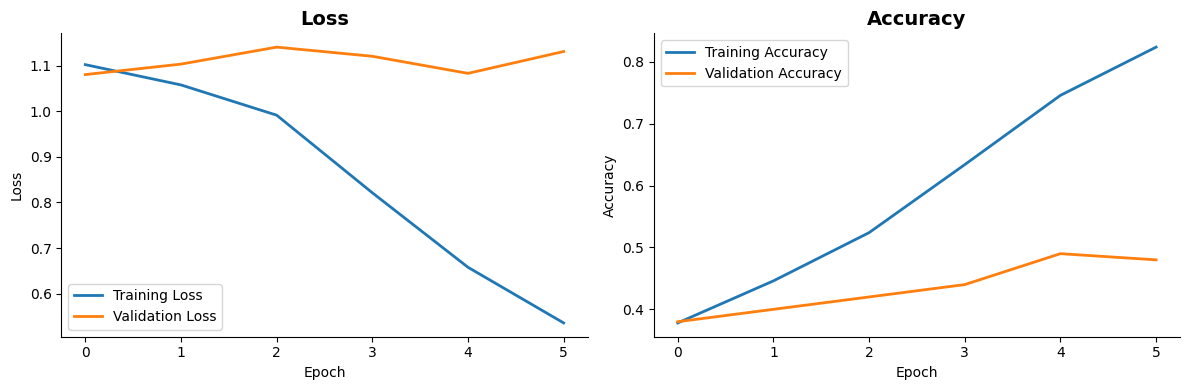

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_32_dir_unidirectional from models\model_layers_1_units_32_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_32_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_32_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Test Macro F1-Score for model_layers_1_units_32_dir_unidirectional: 0.1844
New best overall model 'models\model_layers_1_units_32_dir_unidirectional.keras' copied to 'models\best_model.keras' (Macro F1: 0.1844)
Best overall model configuration saved to models\best_model_config.json


>>>> CONFIGURATION: layers_1_units_32_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_32_dir_bidirectional ---
Model model_layers_1_units_32_dir_bidirectional b

c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_32_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn         │ (None, 64)             │        18,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,138,691 (19.60 MB)

 Trainable params: 5,138,691 (19.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.05736, saving model to models\model_layers_1_units_32_dir_bidirectional.keras
16/16 - 7s - 422ms/step - accuracy: 0.4080 - loss: 1.0692 - val_accuracy: 0.4300 - val_loss: 1.0574
Epoch 2/20

Epoch 2: val_loss improved from 1.05736 to 0.97311, saving model to models\model_layers_1_units_32_dir_bidirectional.keras
16/16 - 2s - 98ms/step - accuracy: 0.8080 - loss: 0.7462 - val_accuracy: 0.5200 - val_loss: 0.9731
Epoch 3/20

Epoch 3: val_loss did not improve from 0.97311
16/16 - 1s - 65ms/step - accuracy: 0.9560 - loss: 0.4175 - val_accuracy: 0.5500 - val_loss: 0.9864
Epoch 4/20

Epoch 4: val_loss improved from 0.97311 to 0.96283, saving model to models\model_layers_1_units_32_dir_bidirectional.keras
16/16 - 1s - 93ms/step - accuracy: 0.9920 - loss: 0.1934 - val_accuracy: 0.5500 - val_loss: 0.9628
Epoch 5/20

Epoch 5: val_loss did not improve from 0.96283
16/16 - 1s - 66ms/step - accuracy: 0.9980 - loss: 0.0899 - val_accuracy: 0.5000 - va

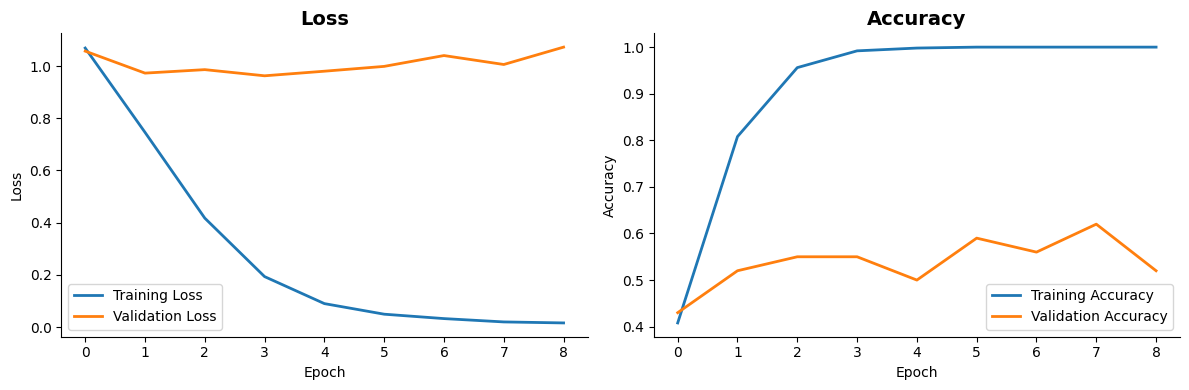

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_32_dir_bidirectional from models\model_layers_1_units_32_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_32_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_32_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Test Macro F1-Score for model_layers_1_units_32_dir_bidirectional: 0.5352
New best overall model 'models\model_layers_1_units_32_dir_bidirectional.keras' copied to 'models\best_model.keras' (Macro F1: 0.5352)
Best overall model configuration saved to models\best_model_config.json

>>>> CONFIGURATION: layers_1_units_64_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_64_dir_unidirectional ---
Model model_layers_1_units_64_dir_unidirectional built

c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_64_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn (SimpleRNN)           │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,140,739 (19.61 MB)

 Trainable params: 5,140,739 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.08780, saving model to models\model_layers_1_units_64_dir_unidirectional.keras
16/16 - 5s - 298ms/step - accuracy: 0.3760 - loss: 1.1110 - val_accuracy: 0.3800 - val_loss: 1.0878
Epoch 2/20

Epoch 2: val_loss improved from 1.08780 to 1.06030, saving model to models\model_layers_1_units_64_dir_unidirectional.keras
16/16 - 1s - 80ms/step - accuracy: 0.4220 - loss: 1.0581 - val_accuracy: 0.4100 - val_loss: 1.0603
Epoch 3/20

Epoch 3: val_loss did not improve from 1.06030
16/16 - 1s - 50ms/step - accuracy: 0.6060 - loss: 0.9236 - val_accuracy: 0.4100 - val_loss: 1.0903
Epoch 4/20

Epoch 4: val_loss did not improve from 1.06030
16/16 - 1s - 51ms/step - accuracy: 0.6840 - loss: 0.7784 - val_accuracy: 0.4500 - val_loss: 1.1294
Epoch 5/20

Epoch 5: val_loss did not improve from 1.06030
16/16 - 1s - 51ms/step - accuracy: 0.7360 - loss: 0.6917 - val_accuracy: 0.3600 - val_loss: 1.3878
Epoch 6/20

Epoch 6: val_loss did not improve from 1.06030


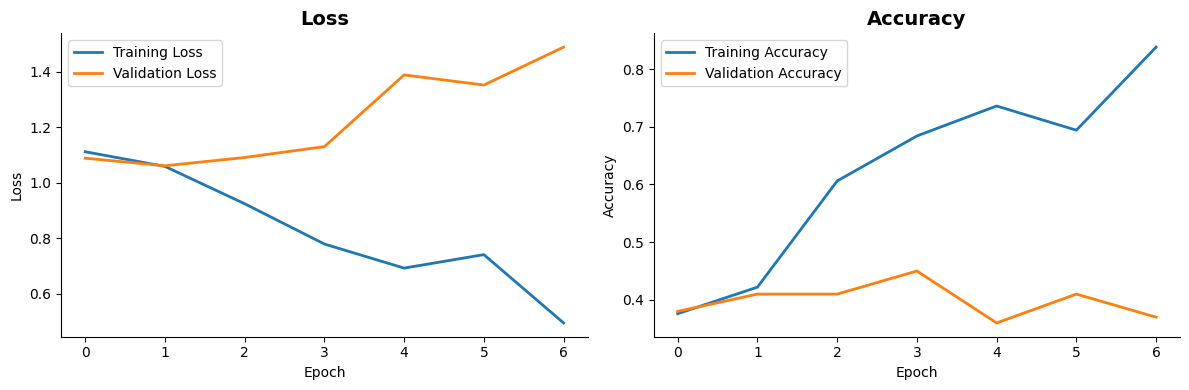

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_64_dir_unidirectional from models\model_layers_1_units_64_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_64_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_64_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Test Macro F1-Score for model_layers_1_units_64_dir_unidirectional: 0.3077

>>>> CONFIGURATION: layers_1_units_64_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_64_dir_bidirectional ---
Model model_layers_1_units_64_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_64_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn         │ (None, 128)            │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,161,475 (19.69 MB)

 Trainable params: 5,161,475 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.95254, saving model to models\model_layers_1_units_64_dir_bidirectional.keras
16/16 - 6s - 397ms/step - accuracy: 0.4400 - loss: 1.0166 - val_accuracy: 0.5200 - val_loss: 0.9525
Epoch 2/20

Epoch 2: val_loss improved from 0.95254 to 0.93101, saving model to models\model_layers_1_units_64_dir_bidirectional.keras
16/16 - 1s - 89ms/step - accuracy: 0.7100 - loss: 0.7430 - val_accuracy: 0.5600 - val_loss: 0.9310
Epoch 3/20

Epoch 3: val_loss did not improve from 0.93101
16/16 - 1s - 56ms/step - accuracy: 0.9220 - loss: 0.4697 - val_accuracy: 0.5500 - val_loss: 0.9759
Epoch 4/20

Epoch 4: val_loss improved from 0.93101 to 0.89393, saving model to models\model_layers_1_units_64_dir_bidirectional.keras
16/16 - 2s - 102ms/step - accuracy: 0.9820 - loss: 0.2247 - val_accuracy: 0.5600 - val_loss: 0.8939
Epoch 5/20

Epoch 5: val_loss did not improve from 0.89393
16/16 - 1s - 58ms/step - accuracy: 0.9940 - loss: 0.0896 - val_accuracy: 0.5700 - v

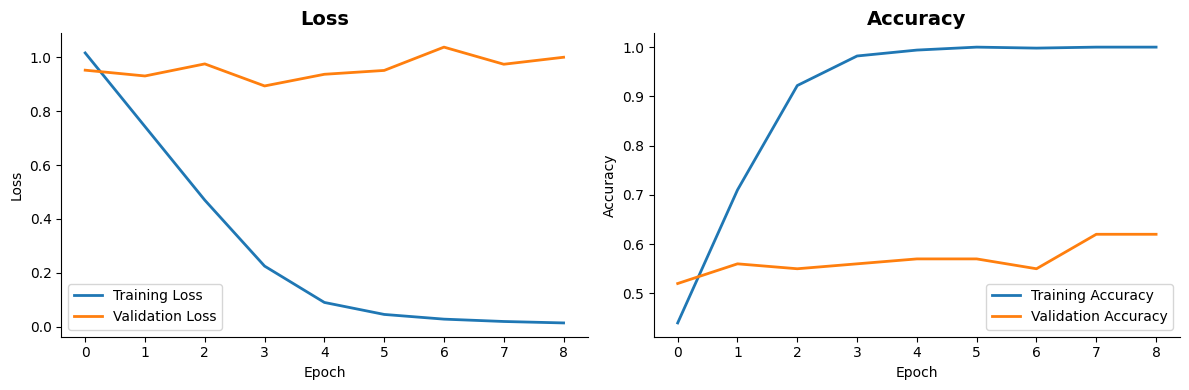

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_64_dir_bidirectional from models\model_layers_1_units_64_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_64_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_64_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Test Macro F1-Score for model_layers_1_units_64_dir_bidirectional: 0.5810
New best overall model 'models\model_layers_1_units_64_dir_bidirectional.keras' copied to 'models\best_model.keras' (Macro F1: 0.5810)
Best overall model configuration saved to models\best_model_config.json

>>>> CONFIGURATION: layers_1_units_128_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_128_dir_unidirectional ---
Model model_layers_1_units_128_dir_unidirectional bu

c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_128_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn (SimpleRNN)           │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,169,667 (19.72 MB)

 Trainable params: 5,169,667 (19.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.06949, saving model to models\model_layers_1_units_128_dir_unidirectional.keras
16/16 - 5s - 315ms/step - accuracy: 0.3540 - loss: 1.1062 - val_accuracy: 0.4100 - val_loss: 1.0695
Epoch 2/20

Epoch 2: val_loss did not improve from 1.06949
16/16 - 1s - 62ms/step - accuracy: 0.3660 - loss: 1.0966 - val_accuracy: 0.3700 - val_loss: 1.0860
Epoch 3/20

Epoch 3: val_loss did not improve from 1.06949
16/16 - 1s - 59ms/step - accuracy: 0.4680 - loss: 1.0562 - val_accuracy: 0.3900 - val_loss: 1.1546
Epoch 4/20

Epoch 4: val_loss did not improve from 1.06949
16/16 - 1s - 58ms/step - accuracy: 0.4520 - loss: 1.0307 - val_accuracy: 0.3100 - val_loss: 1.2385
Epoch 5/20

Epoch 5: val_loss did not improve from 1.06949
16/16 - 1s - 59ms/step - accuracy: 0.5760 - loss: 0.8907 - val_accuracy: 0.4300 - val_loss: 1.1954
Epoch 6/20

Epoch 6: val_loss did not improve from 1.06949
16/16 - 1s - 58ms/step - accuracy: 0.6600 - loss: 0.7681 - val_accuracy: 0.3

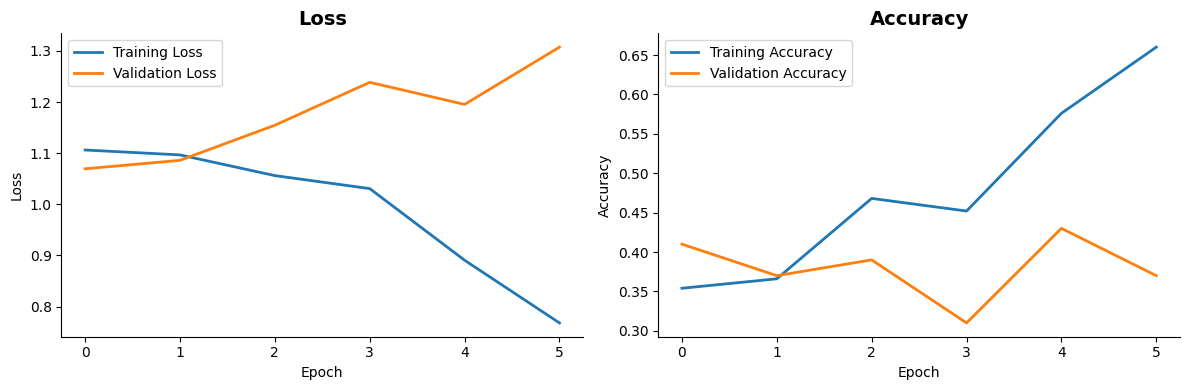

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_128_dir_unidirectional from models\model_layers_1_units_128_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_128_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_128_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Test Macro F1-Score for model_layers_1_units_128_dir_unidirectional: 0.3982

>>>> CONFIGURATION: layers_1_units_128_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_128_dir_bidirectional ---
Model model_layers_1_units_128_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_128_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn         │ (None, 256)            │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,219,331 (19.91 MB)

 Trainable params: 5,219,331 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.95886, saving model to models\model_layers_1_units_128_dir_bidirectional.keras
16/16 - 7s - 450ms/step - accuracy: 0.4240 - loss: 1.0502 - val_accuracy: 0.5200 - val_loss: 0.9589
Epoch 2/20

Epoch 2: val_loss improved from 0.95886 to 0.93763, saving model to models\model_layers_1_units_128_dir_bidirectional.keras
16/16 - 2s - 122ms/step - accuracy: 0.7860 - loss: 0.6856 - val_accuracy: 0.5600 - val_loss: 0.9376
Epoch 3/20

Epoch 3: val_loss improved from 0.93763 to 0.92439, saving model to models\model_layers_1_units_128_dir_bidirectional.keras
16/16 - 2s - 125ms/step - accuracy: 0.9460 - loss: 0.3021 - val_accuracy: 0.5800 - val_loss: 0.9244
Epoch 4/20

Epoch 4: val_loss improved from 0.92439 to 0.90070, saving model to models\model_layers_1_units_128_dir_bidirectional.keras
16/16 - 3s - 168ms/step - accuracy: 0.9880 - loss: 0.1239 - val_accuracy: 0.5500 - val_loss: 0.9007
Epoch 5/20

Epoch 5: val_loss did not improve from 0.90070
1

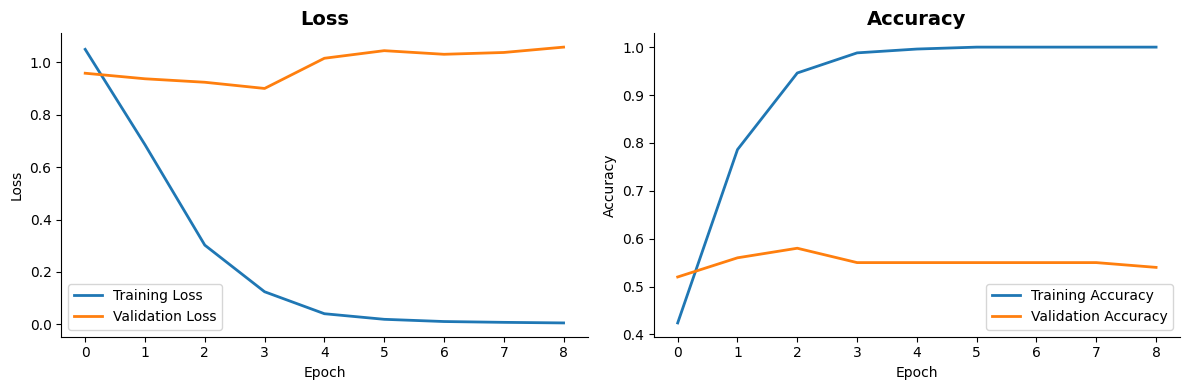

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_128_dir_bidirectional from models\model_layers_1_units_128_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_128_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_128_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Test Macro F1-Score for model_layers_1_units_128_dir_bidirectional: 0.5173

>>>> CONFIGURATION: layers_2_units_32_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_32_dir_unidirectional ---
Model model_layers_2_units_32_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_32_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,131,427 (19.57 MB)

 Trainable params: 5,131,427 (19.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.07871, saving model to models\model_layers_2_units_32_dir_unidirectional.keras
16/16 - 7s - 430ms/step - accuracy: 0.3560 - loss: 1.1476 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 2/20

Epoch 2: val_loss did not improve from 1.07871
16/16 - 1s - 88ms/step - accuracy: 0.4180 - loss: 1.0750 - val_accuracy: 0.3300 - val_loss: 1.1374
Epoch 3/20

Epoch 3: val_loss did not improve from 1.07871
16/16 - 2s - 96ms/step - accuracy: 0.6620 - loss: 0.7920 - val_accuracy: 0.3600 - val_loss: 1.2805
Epoch 4/20

Epoch 4: val_loss did not improve from 1.07871
16/16 - 1s - 90ms/step - accuracy: 0.7400 - loss: 0.6075 - val_accuracy: 0.4200 - val_loss: 1.4411
Epoch 5/20

Epoch 5: val_loss did not improve from 1.07871
16/16 - 1s - 90ms/step - accuracy: 0.9260 - loss: 0.3141 - val_accuracy: 0.3700 - val_loss: 1.6890
Epoch 6/20

Epoch 6: val_loss did not improve from 1.07871
16/16 - 1s - 91ms/step - accuracy: 0.9760 - loss: 0.1492 - val_accuracy: 0.40

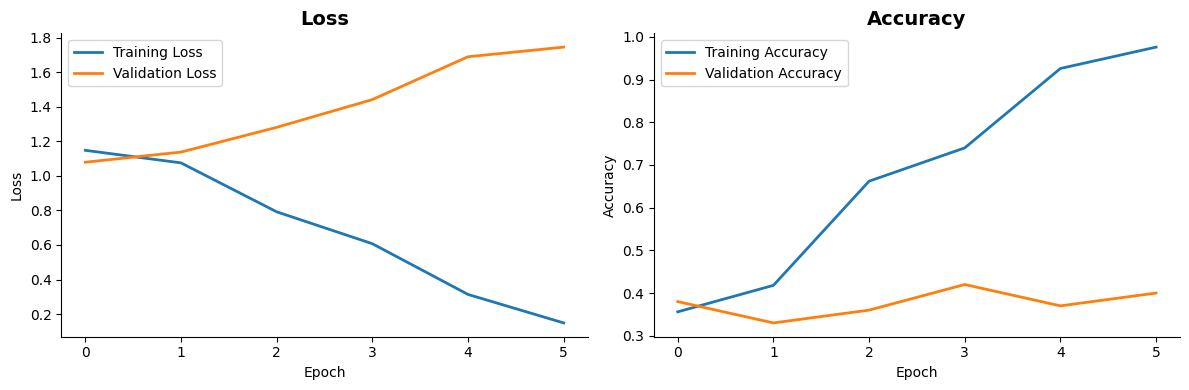

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_32_dir_unidirectional from models\model_layers_2_units_32_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_32_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_32_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Test Macro F1-Score for model_layers_2_units_32_dir_unidirectional: 0.1892

>>>> CONFIGURATION: layers_2_units_32_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_32_dir_bidirectional ---
Model model_layers_2_units_32_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_32_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 64)        │        18,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 64)             │         6,208 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,144,899 (19.63 MB)

 Trainable params: 5,144,899 (19.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.02314, saving model to models\model_layers_2_units_32_dir_bidirectional.keras
16/16 - 11s - 707ms/step - accuracy: 0.4100 - loss: 1.0991 - val_accuracy: 0.4900 - val_loss: 1.0231
Epoch 2/20

Epoch 2: val_loss improved from 1.02314 to 1.02263, saving model to models\model_layers_2_units_32_dir_bidirectional.keras
16/16 - 3s - 163ms/step - accuracy: 0.8360 - loss: 0.5520 - val_accuracy: 0.4800 - val_loss: 1.0226
Epoch 3/20

Epoch 3: val_loss did not improve from 1.02263
16/16 - 2s - 121ms/step - accuracy: 0.9760 - loss: 0.2088 - val_accuracy: 0.4700 - val_loss: 1.1774
Epoch 4/20

Epoch 4: val_loss did not improve from 1.02263
16/16 - 2s - 121ms/step - accuracy: 0.9980 - loss: 0.0736 - val_accuracy: 0.4400 - val_loss: 1.2275
Epoch 5/20

Epoch 5: val_loss did not improve from 1.02263
16/16 - 2s - 114ms/step - accuracy: 1.0000 - loss: 0.0305 - val_accuracy: 0.3500 - val_loss: 1.4015
Epoch 6/20

Epoch 6: val_loss did not improve from 1.022

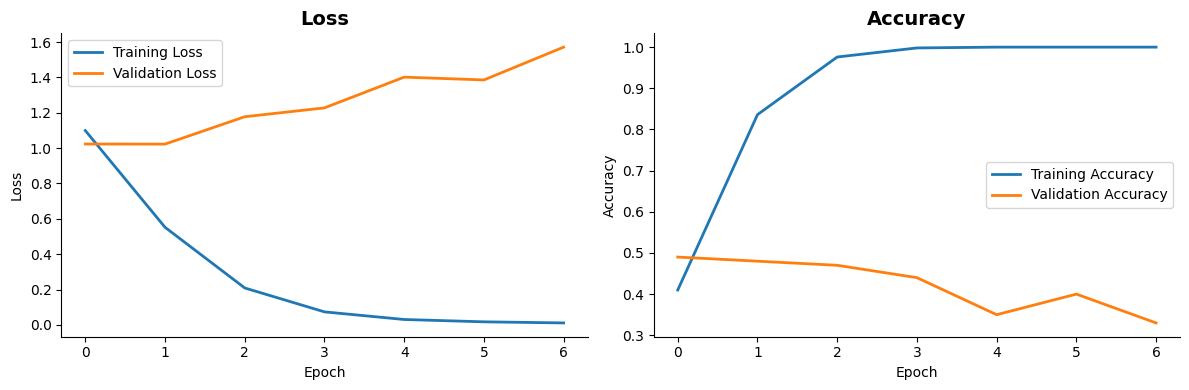

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_32_dir_bidirectional from models\model_layers_2_units_32_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_32_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_32_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step
Test Macro F1-Score for model_layers_2_units_32_dir_bidirectional: 0.5317

>>>> CONFIGURATION: layers_2_units_64_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_64_dir_unidirectional ---
Model model_layers_2_units_64_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_64_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,148,995 (19.64 MB)

 Trainable params: 5,148,995 (19.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.09426, saving model to models\model_layers_2_units_64_dir_unidirectional.keras
16/16 - 7s - 424ms/step - accuracy: 0.3960 - loss: 1.1226 - val_accuracy: 0.3900 - val_loss: 1.0943
Epoch 2/20

Epoch 2: val_loss did not improve from 1.09426
16/16 - 1s - 81ms/step - accuracy: 0.4420 - loss: 1.0928 - val_accuracy: 0.3800 - val_loss: 1.2467
Epoch 3/20

Epoch 3: val_loss did not improve from 1.09426
16/16 - 1s - 79ms/step - accuracy: 0.4400 - loss: 1.2035 - val_accuracy: 0.3800 - val_loss: 1.1615
Epoch 4/20

Epoch 4: val_loss did not improve from 1.09426
16/16 - 1s - 75ms/step - accuracy: 0.4720 - loss: 1.2105 - val_accuracy: 0.4000 - val_loss: 1.3027
Epoch 5/20

Epoch 5: val_loss did not improve from 1.09426
16/16 - 1s - 77ms/step - accuracy: 0.4200 - loss: 1.1464 - val_accuracy: 0.4400 - val_loss: 1.1230
Epoch 6/20

Epoch 6: val_loss did not improve from 1.09426
16/16 - 1s - 75ms/step - accuracy: 0.5320 - loss: 1.0041 - val_accuracy: 0.47

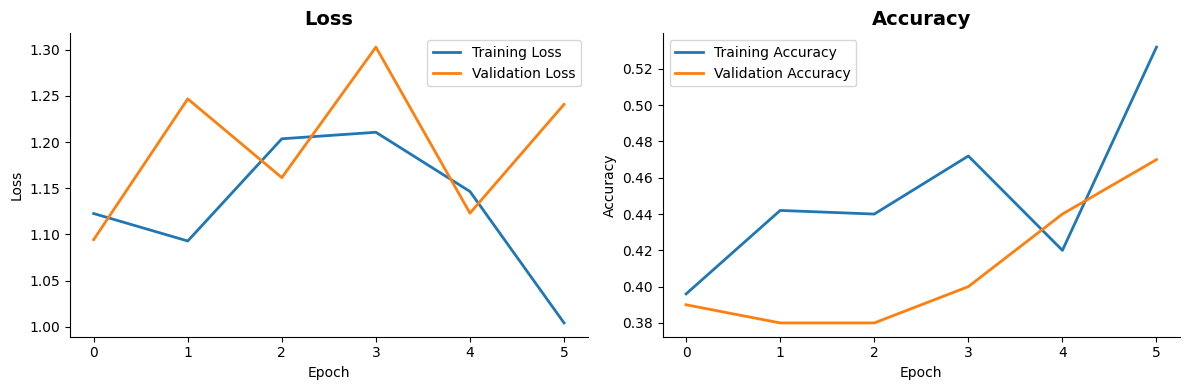

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_64_dir_unidirectional from models\model_layers_2_units_64_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_64_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_64_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Test Macro F1-Score for model_layers_2_units_64_dir_unidirectional: 0.2643

>>>> CONFIGURATION: layers_2_units_64_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_64_dir_bidirectional ---
Model model_layers_2_units_64_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_64_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 128)       │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 128)            │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,186,179 (19.78 MB)

 Trainable params: 5,186,179 (19.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.99652, saving model to models\model_layers_2_units_64_dir_bidirectional.keras
16/16 - 11s - 707ms/step - accuracy: 0.4260 - loss: 1.0913 - val_accuracy: 0.5000 - val_loss: 0.9965
Epoch 2/20

Epoch 2: val_loss improved from 0.99652 to 0.88965, saving model to models\model_layers_2_units_64_dir_bidirectional.keras
16/16 - 2s - 142ms/step - accuracy: 0.7840 - loss: 0.6086 - val_accuracy: 0.6100 - val_loss: 0.8896
Epoch 3/20

Epoch 3: val_loss did not improve from 0.88965
16/16 - 2s - 111ms/step - accuracy: 0.9740 - loss: 0.1898 - val_accuracy: 0.5800 - val_loss: 0.9693
Epoch 4/20

Epoch 4: val_loss did not improve from 0.88965
16/16 - 2s - 106ms/step - accuracy: 0.9940 - loss: 0.0680 - val_accuracy: 0.5000 - val_loss: 1.0800
Epoch 5/20

Epoch 5: val_loss did not improve from 0.88965
16/16 - 2s - 106ms/step - accuracy: 1.0000 - loss: 0.0243 - val_accuracy: 0.5000 - val_loss: 1.1503
Epoch 6/20

Epoch 6: val_loss did not improve from 0.889

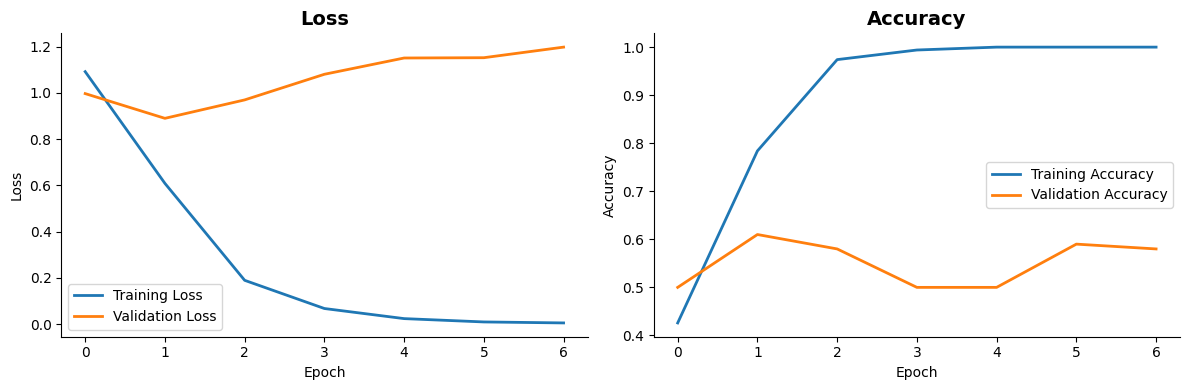

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_64_dir_bidirectional from models\model_layers_2_units_64_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_64_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_64_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
Test Macro F1-Score for model_layers_2_units_64_dir_bidirectional: 0.4982

>>>> CONFIGURATION: layers_2_units_128_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_128_dir_unidirectional ---
Model model_layers_2_units_128_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_128_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,202,563 (19.85 MB)

 Trainable params: 5,202,563 (19.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.11772, saving model to models\model_layers_2_units_128_dir_unidirectional.keras
16/16 - 7s - 426ms/step - accuracy: 0.3740 - loss: 1.2018 - val_accuracy: 0.3800 - val_loss: 1.1177
Epoch 2/20

Epoch 2: val_loss did not improve from 1.11772
16/16 - 1s - 79ms/step - accuracy: 0.3460 - loss: 1.1889 - val_accuracy: 0.3800 - val_loss: 1.3742
Epoch 3/20

Epoch 3: val_loss did not improve from 1.11772
16/16 - 1s - 79ms/step - accuracy: 0.4700 - loss: 1.0922 - val_accuracy: 0.3100 - val_loss: 1.4960
Epoch 4/20

Epoch 4: val_loss did not improve from 1.11772
16/16 - 1s - 79ms/step - accuracy: 0.4000 - loss: 1.3705 - val_accuracy: 0.3600 - val_loss: 1.4517
Epoch 5/20

Epoch 5: val_loss improved from 1.11772 to 1.09735, saving model to models\model_layers_2_units_128_dir_unidirectional.keras
16/16 - 2s - 107ms/step - accuracy: 0.3840 - loss: 1.1940 - val_accuracy: 0.3800 - val_loss: 1.0974
Epoch 6/20

Epoch 6: val_loss did not improve from 1.097

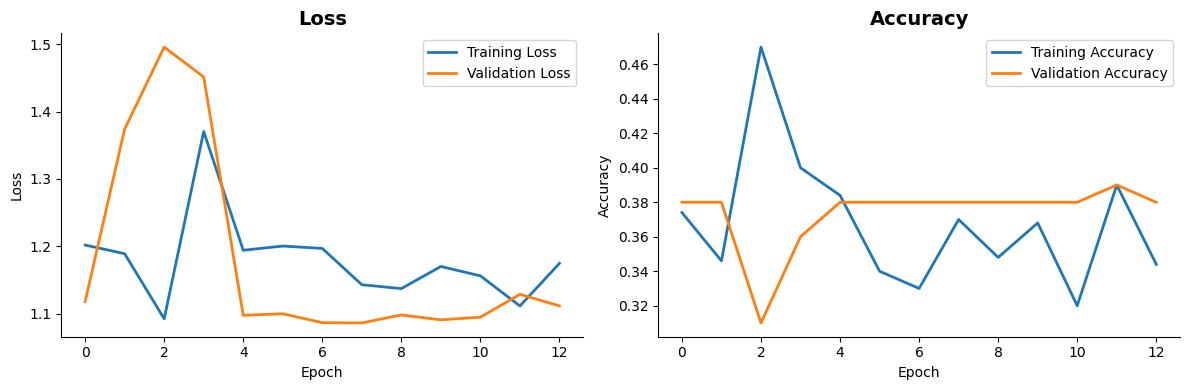

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_128_dir_unidirectional from models\model_layers_2_units_128_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_128_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_128_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Test Macro F1-Score for model_layers_2_units_128_dir_unidirectional: 0.1844

>>>> CONFIGURATION: layers_2_units_128_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_128_dir_bidirectional ---
Model model_layers_2_units_128_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_128_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 256)       │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 256)            │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,317,891 (20.29 MB)

 Trainable params: 5,317,891 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.20329, saving model to models\model_layers_2_units_128_dir_bidirectional.keras
16/16 - 11s - 685ms/step - accuracy: 0.3560 - loss: 1.2191 - val_accuracy: 0.4000 - val_loss: 1.2033
Epoch 2/20

Epoch 2: val_loss improved from 1.20329 to 1.12541, saving model to models\model_layers_2_units_128_dir_bidirectional.keras
16/16 - 3s - 166ms/step - accuracy: 0.6680 - loss: 0.7515 - val_accuracy: 0.4400 - val_loss: 1.1254
Epoch 3/20

Epoch 3: val_loss did not improve from 1.12541
16/16 - 2s - 133ms/step - accuracy: 0.9680 - loss: 0.1513 - val_accuracy: 0.3300 - val_loss: 1.4969
Epoch 4/20

Epoch 4: val_loss did not improve from 1.12541
16/16 - 2s - 131ms/step - accuracy: 1.0000 - loss: 0.0207 - val_accuracy: 0.3300 - val_loss: 1.6297
Epoch 5/20

Epoch 5: val_loss did not improve from 1.12541
16/16 - 2s - 131ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.3500 - val_loss: 1.7891
Epoch 6/20

Epoch 6: val_loss did not improve from 1.1

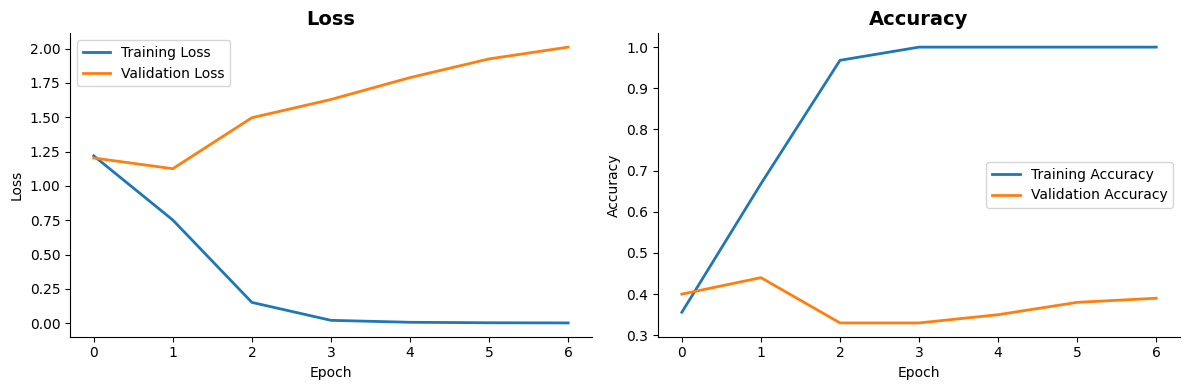

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_128_dir_bidirectional from models\model_layers_2_units_128_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_128_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_128_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
Test Macro F1-Score for model_layers_2_units_128_dir_bidirectional: 0.4230

>>>> CONFIGURATION: layers_3_units_32_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_32_dir_unidirectional ---
Model model_layers_3_units_32_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_3_units_32_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 120, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_3 (SimpleRNN)         │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,133,507 (19.58 MB)

 Trainable params: 5,133,507 (19.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.13024, saving model to models\model_layers_3_units_32_dir_unidirectional.keras
16/16 - 9s - 560ms/step - accuracy: 0.3900 - loss: 1.0982 - val_accuracy: 0.2400 - val_loss: 1.1302
Epoch 2/20

Epoch 2: val_loss improved from 1.13024 to 1.09553, saving model to models\model_layers_3_units_32_dir_unidirectional.keras
16/16 - 2s - 135ms/step - accuracy: 0.3340 - loss: 1.1434 - val_accuracy: 0.3800 - val_loss: 1.0955
Epoch 3/20

Epoch 3: val_loss improved from 1.09553 to 1.08547, saving model to models\model_layers_3_units_32_dir_unidirectional.keras
16/16 - 2s - 141ms/step - accuracy: 0.4020 - loss: 1.1308 - val_accuracy: 0.3800 - val_loss: 1.0855
Epoch 4/20

Epoch 4: val_loss did not improve from 1.08547
16/16 - 2s - 106ms/step - accuracy: 0.5320 - loss: 0.9680 - val_accuracy: 0.4000 - val_loss: 1.3991
Epoch 5/20

Epoch 5: val_loss did not improve from 1.08547
16/16 - 2s - 110ms/step - accuracy: 0.6300 - loss: 0.8161 - val_accuracy: 0.31

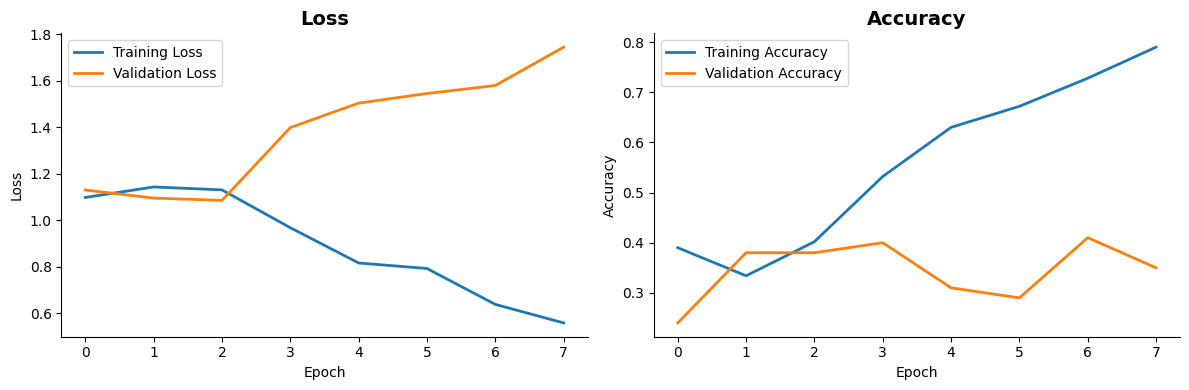

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_32_dir_unidirectional from models\model_layers_3_units_32_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_32_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_32_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
Test Macro F1-Score for model_layers_3_units_32_dir_unidirectional: 0.1891

>>>> CONFIGURATION: layers_3_units_32_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_32_dir_bidirectional ---
Model model_layers_3_units_32_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_3_units_32_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 64)        │        18,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 120, 64)        │         6,208 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_3       │ (None, 64)             │         6,208 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,151,107 (19.65 MB)

 Trainable params: 5,151,107 (19.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.92354, saving model to models\model_layers_3_units_32_dir_bidirectional.keras
16/16 - 17s - 1s/step - accuracy: 0.4700 - loss: 1.0217 - val_accuracy: 0.5600 - val_loss: 0.9235
Epoch 2/20

Epoch 2: val_loss improved from 0.92354 to 0.88455, saving model to models\model_layers_3_units_32_dir_bidirectional.keras
16/16 - 4s - 274ms/step - accuracy: 0.8020 - loss: 0.5515 - val_accuracy: 0.6200 - val_loss: 0.8845
Epoch 3/20

Epoch 3: val_loss did not improve from 0.88455
16/16 - 4s - 256ms/step - accuracy: 0.9480 - loss: 0.2506 - val_accuracy: 0.5800 - val_loss: 0.9125
Epoch 4/20

Epoch 4: val_loss did not improve from 0.88455
16/16 - 4s - 241ms/step - accuracy: 0.9980 - loss: 0.0915 - val_accuracy: 0.5500 - val_loss: 1.0087
Epoch 5/20

Epoch 5: val_loss did not improve from 0.88455
16/16 - 4s - 255ms/step - accuracy: 1.0000 - loss: 0.0410 - val_accuracy: 0.5600 - val_loss: 1.0477
Epoch 6/20

Epoch 6: val_loss did not improve from 0.88455


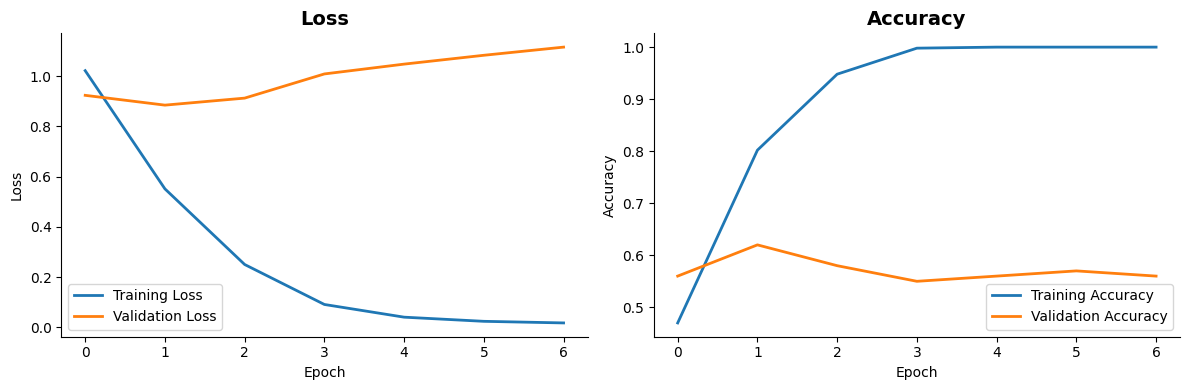

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_32_dir_bidirectional from models\model_layers_3_units_32_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_32_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_32_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step
Test Macro F1-Score for model_layers_3_units_32_dir_bidirectional: 0.5336

>>>> CONFIGURATION: layers_3_units_64_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_64_dir_unidirectional ---
Model model_layers_3_units_64_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_3_units_64_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 120, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_3 (SimpleRNN)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,157,251 (19.67 MB)

 Trainable params: 5,157,251 (19.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.07916, saving model to models\model_layers_3_units_64_dir_unidirectional.keras
16/16 - 10s - 639ms/step - accuracy: 0.3340 - loss: 1.1895 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 2/20

Epoch 2: val_loss did not improve from 1.07916
16/16 - 3s - 165ms/step - accuracy: 0.3640 - loss: 1.1386 - val_accuracy: 0.3800 - val_loss: 1.1154
Epoch 3/20

Epoch 3: val_loss did not improve from 1.07916
16/16 - 3s - 171ms/step - accuracy: 0.5500 - loss: 0.9569 - val_accuracy: 0.3200 - val_loss: 1.3234
Epoch 4/20

Epoch 4: val_loss did not improve from 1.07916
16/16 - 3s - 165ms/step - accuracy: 0.6820 - loss: 0.7512 - val_accuracy: 0.3300 - val_loss: 1.5231
Epoch 5/20

Epoch 5: val_loss did not improve from 1.07916
16/16 - 3s - 172ms/step - accuracy: 0.6680 - loss: 0.7567 - val_accuracy: 0.2800 - val_loss: 1.4847
Epoch 6/20

Epoch 6: val_loss did not improve from 1.07916
16/16 - 3s - 165ms/step - accuracy: 0.8960 - loss: 0.3380 - val_accuracy

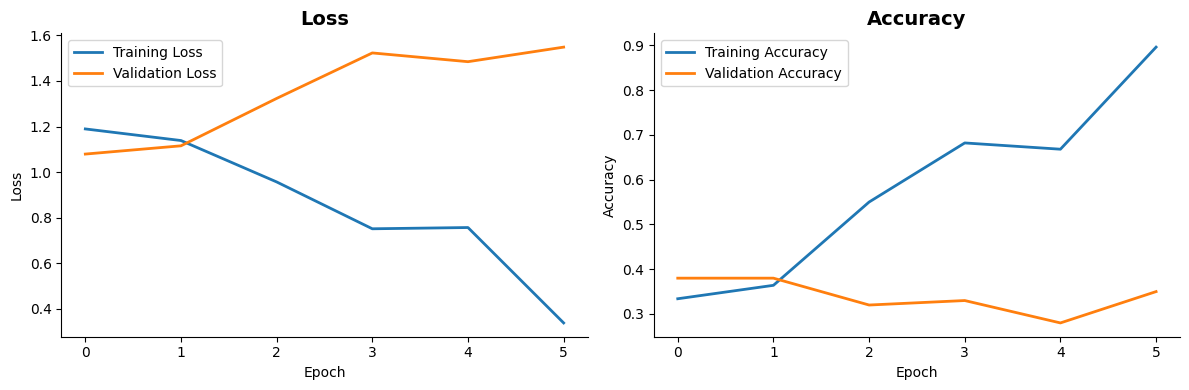

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_64_dir_unidirectional from models\model_layers_3_units_64_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_64_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_64_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
Test Macro F1-Score for model_layers_3_units_64_dir_unidirectional: 0.1827

>>>> CONFIGURATION: layers_3_units_64_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_64_dir_bidirectional ---


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model model_layers_3_units_64_dir_bidirectional built with input shape: (None,)


Model: "model_layers_3_units_64_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 128)       │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 120, 128)       │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_3       │ (None, 128)            │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,210,883 (19.88 MB)

 Trainable params: 5,210,883 (19.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.20071, saving model to models\model_layers_3_units_64_dir_bidirectional.keras
16/16 - 16s - 1s/step - accuracy: 0.3240 - loss: 1.2393 - val_accuracy: 0.3800 - val_loss: 1.2007
Epoch 2/20

Epoch 2: val_loss did not improve from 1.20071
16/16 - 3s - 177ms/step - accuracy: 0.4320 - loss: 1.1100 - val_accuracy: 0.3700 - val_loss: 1.3426
Epoch 3/20

Epoch 3: val_loss improved from 1.20071 to 1.11979, saving model to models\model_layers_3_units_64_dir_bidirectional.keras
16/16 - 3s - 215ms/step - accuracy: 0.7900 - loss: 0.6037 - val_accuracy: 0.4700 - val_loss: 1.1198
Epoch 4/20

Epoch 4: val_loss did not improve from 1.11979
16/16 - 3s - 178ms/step - accuracy: 0.9860 - loss: 0.1046 - val_accuracy: 0.4900 - val_loss: 1.3010
Epoch 5/20

Epoch 5: val_loss did not improve from 1.11979
16/16 - 3s - 175ms/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 0.4500 - val_loss: 1.4376
Epoch 6/20

Epoch 6: val_loss did not improve from 1.11979


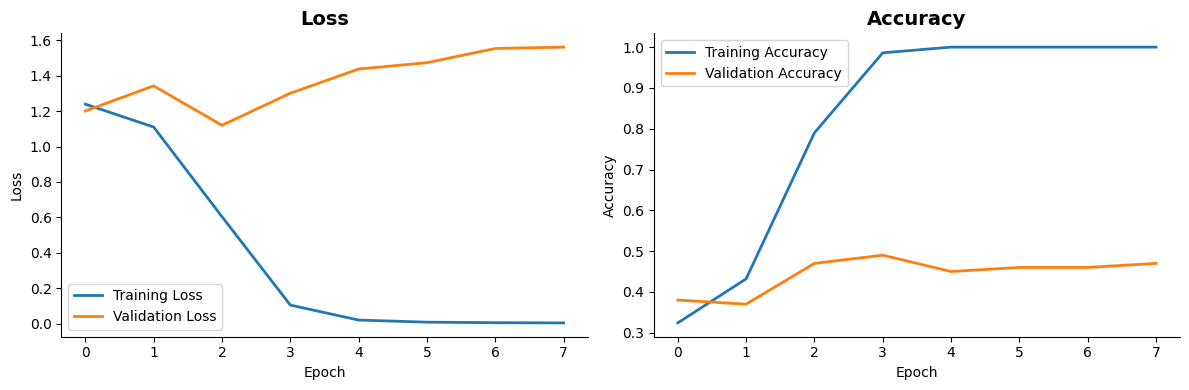

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_64_dir_bidirectional from models\model_layers_3_units_64_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_64_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_64_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step
Test Macro F1-Score for model_layers_3_units_64_dir_bidirectional: 0.4604

>>>> CONFIGURATION: layers_3_units_128_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_128_dir_unidirectional ---
Model model_layers_3_units_128_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_3_units_128_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 120, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_3 (SimpleRNN)         │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,235,459 (19.97 MB)

 Trainable params: 5,235,459 (19.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.18384, saving model to models\model_layers_3_units_128_dir_unidirectional.keras
16/16 - 9s - 560ms/step - accuracy: 0.3380 - loss: 1.3372 - val_accuracy: 0.3800 - val_loss: 1.1838
Epoch 2/20

Epoch 2: val_loss improved from 1.18384 to 1.11656, saving model to models\model_layers_3_units_128_dir_unidirectional.keras
16/16 - 2s - 149ms/step - accuracy: 0.3200 - loss: 1.3072 - val_accuracy: 0.3800 - val_loss: 1.1166
Epoch 3/20

Epoch 3: val_loss improved from 1.11656 to 1.09242, saving model to models\model_layers_3_units_128_dir_unidirectional.keras
16/16 - 2s - 146ms/step - accuracy: 0.3460 - loss: 1.2370 - val_accuracy: 0.3800 - val_loss: 1.0924
Epoch 4/20

Epoch 4: val_loss improved from 1.09242 to 1.07972, saving model to models\model_layers_3_units_128_dir_unidirectional.keras
16/16 - 2s - 145ms/step - accuracy: 0.3580 - loss: 1.2113 - val_accuracy: 0.3800 - val_loss: 1.0797
Epoch 5/20

Epoch 5: val_loss did not improve from 1.079

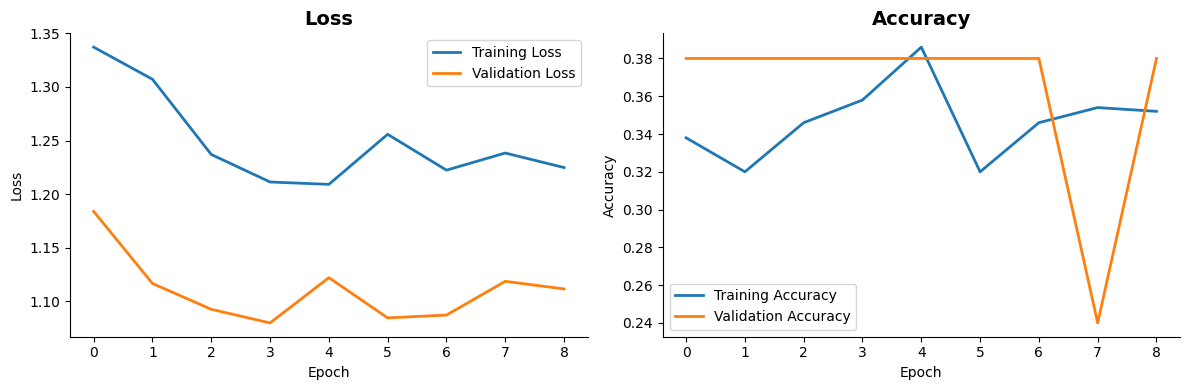

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_128_dir_unidirectional from models\model_layers_3_units_128_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_128_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_128_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
Test Macro F1-Score for model_layers_3_units_128_dir_unidirectional: 0.1827

>>>> CONFIGURATION: layers_3_units_128_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_128_dir_bidirectional ---


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model model_layers_3_units_128_dir_bidirectional built with input shape: (None,)


Model: "model_layers_3_units_128_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 256)       │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 120, 256)       │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_3       │ (None, 256)            │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,416,451 (20.66 MB)

 Trainable params: 5,416,451 (20.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.14892, saving model to models\model_layers_3_units_128_dir_bidirectional.keras
16/16 - 16s - 984ms/step - accuracy: 0.4260 - loss: 1.1953 - val_accuracy: 0.3800 - val_loss: 1.1489
Epoch 2/20

Epoch 2: val_loss did not improve from 1.14892
16/16 - 3s - 200ms/step - accuracy: 0.7340 - loss: 0.6151 - val_accuracy: 0.4300 - val_loss: 1.1687
Epoch 3/20

Epoch 3: val_loss did not improve from 1.14892
16/16 - 3s - 202ms/step - accuracy: 0.9680 - loss: 0.1236 - val_accuracy: 0.4900 - val_loss: 1.4537
Epoch 4/20

Epoch 4: val_loss did not improve from 1.14892
16/16 - 3s - 198ms/step - accuracy: 0.9980 - loss: 0.0197 - val_accuracy: 0.5000 - val_loss: 1.5254
Epoch 5/20

Epoch 5: val_loss did not improve from 1.14892
16/16 - 3s - 202ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.4900 - val_loss: 1.5604
Epoch 6/20

Epoch 6: val_loss did not improve from 1.14892
16/16 - 3s - 195ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy

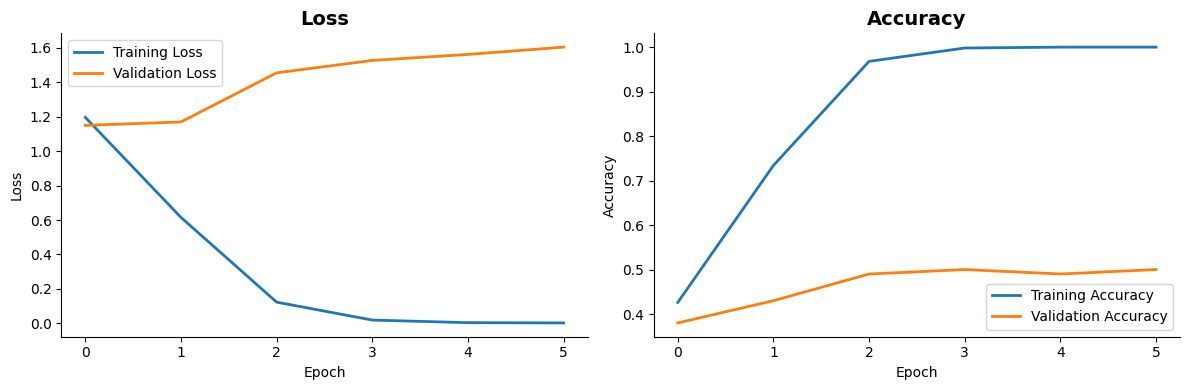

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_128_dir_bidirectional from models\model_layers_3_units_128_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_128_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_128_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step
Test Macro F1-Score for model_layers_3_units_128_dir_bidirectional: 0.1844

--- Hyperparameter Sweep Results ---
Config: layers_1_units_64_dir_bidirectional           | RNN Type: SimpleRNN  | Macro F1: 0.5810
Config: layers_1_units_32_dir_bidirectional           | RNN Type: SimpleRNN  | Macro F1: 0.5352
Config: layers_3_units_32_dir_bidirectional           | RNN Type: SimpleRNN  | Macro F1: 0.5336
Config: layers_2_units_32_dir_bidirectional           | RNN Type: SimpleRNN  | Mac

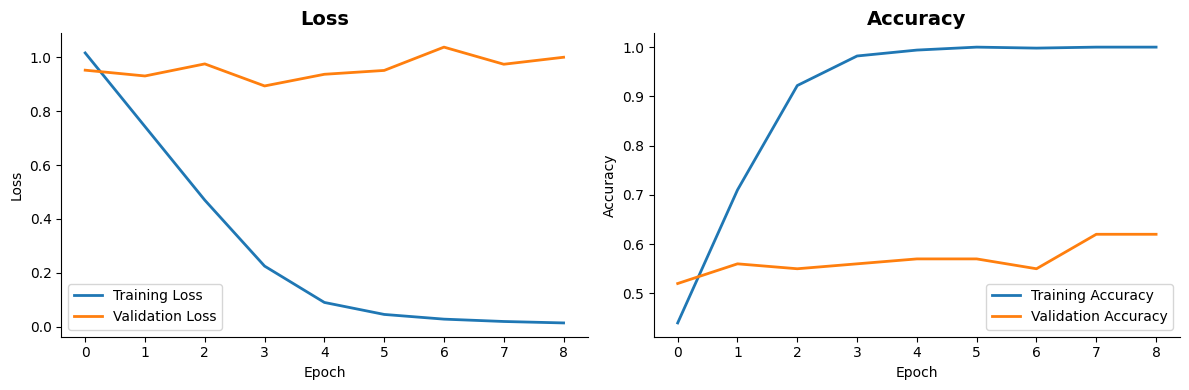

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 1 layer(s) (config: layers_1_units_64_dir_bidirectional, F1: 0.5810) as metrics_curves_Best_1_layer_f1.png
Final Training Loss: 0.0111
Final Training Accuracy: 1.0000
Final Validation Loss: 1.5712
Final Validation Accuracy: 0.3300
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_2_layer_f1.png


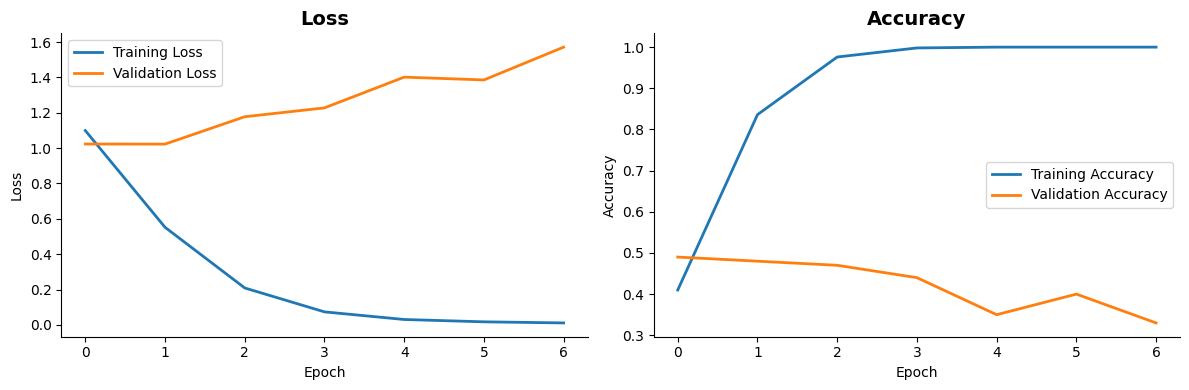

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 2 layer(s) (config: layers_2_units_32_dir_bidirectional, F1: 0.5317) as metrics_curves_Best_2_layer_f1.png
Final Training Loss: 0.0181
Final Training Accuracy: 1.0000
Final Validation Loss: 1.1153
Final Validation Accuracy: 0.5600
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_3_layer_f1.png


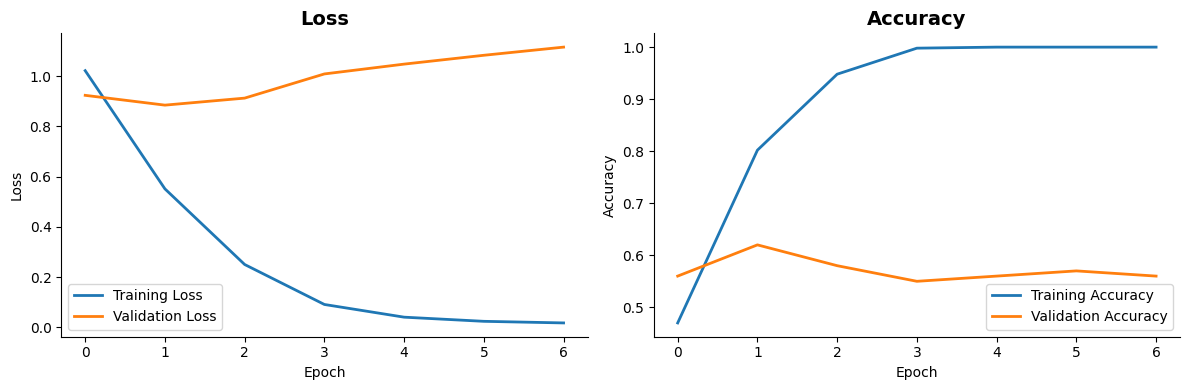

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 3 layer(s) (config: layers_3_units_32_dir_bidirectional, F1: 0.5336) as metrics_curves_Best_3_layer_f1.png
Final Training Loss: 0.0159
Final Training Accuracy: 1.0000
Final Validation Loss: 1.0727
Final Validation Accuracy: 0.5200
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_32_units_f1.png


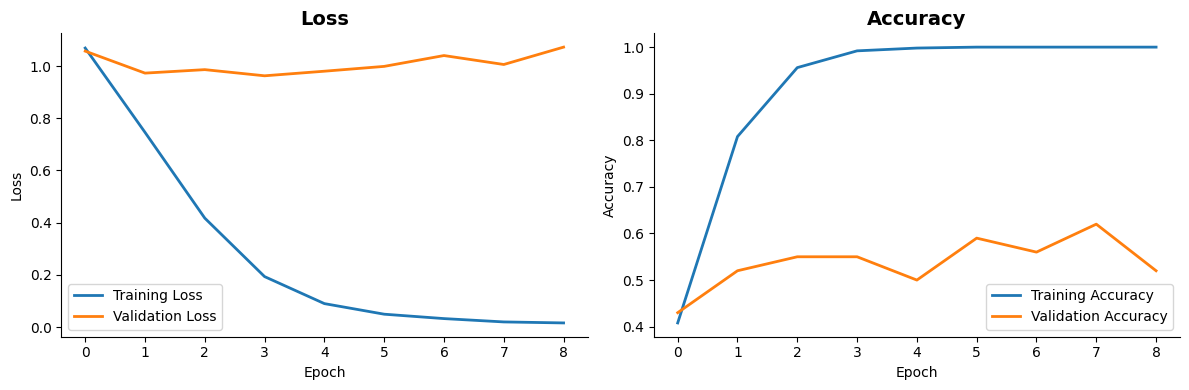

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 32 units (config: layers_1_units_32_dir_bidirectional, F1: 0.5352) as metrics_curves_Best_32_units_f1.png
Final Training Loss: 0.0135
Final Training Accuracy: 1.0000
Final Validation Loss: 1.0006
Final Validation Accuracy: 0.6200
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_64_units_f1.png


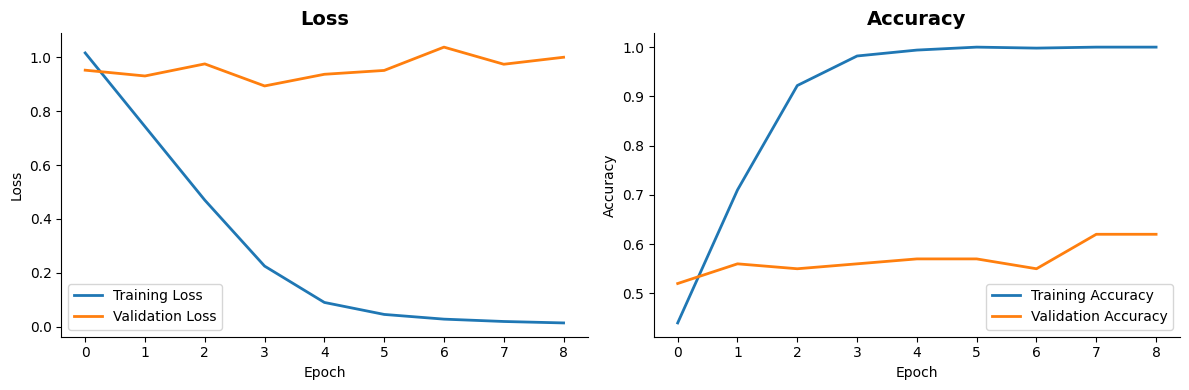

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 64 units (config: layers_1_units_64_dir_bidirectional, F1: 0.5810) as metrics_curves_Best_64_units_f1.png
Final Training Loss: 0.0048
Final Training Accuracy: 1.0000
Final Validation Loss: 1.0586
Final Validation Accuracy: 0.5400
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_128_units_f1.png


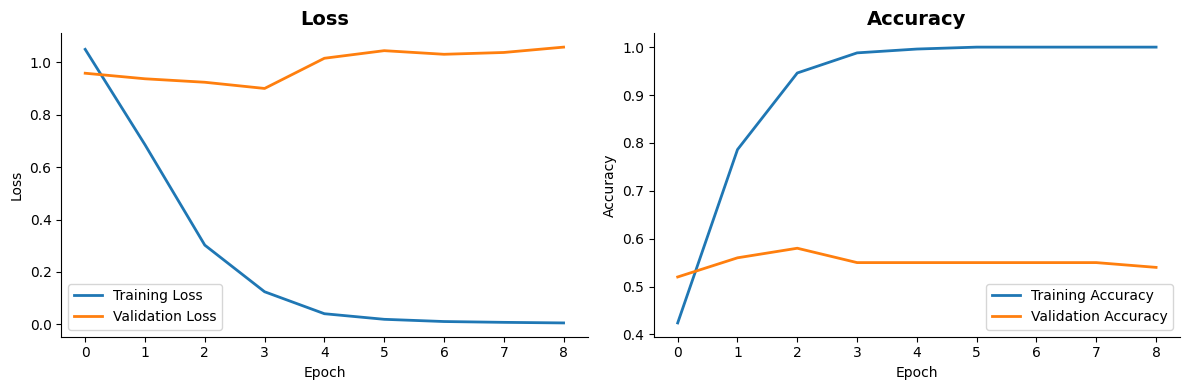

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 128 units (config: layers_1_units_128_dir_bidirectional, F1: 0.5173) as metrics_curves_Best_128_units_f1.png
Final Training Loss: 0.7681
Final Training Accuracy: 0.6600
Final Validation Loss: 1.3074
Final Validation Accuracy: 0.3700
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_unidirectional_f1.png


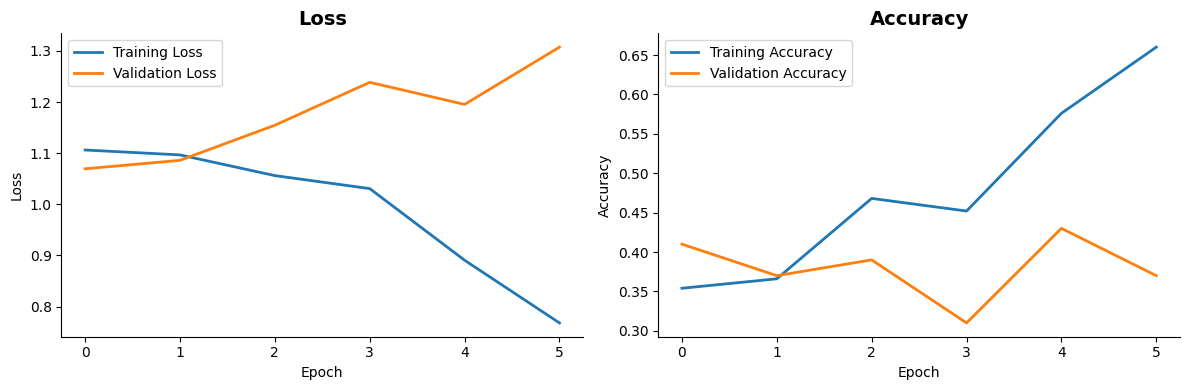

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best unidirectional RNN (config: layers_1_units_128_dir_unidirectional, F1: 0.3982) as metrics_curves_Best_unidirectional_f1.png
Final Training Loss: 0.0135
Final Training Accuracy: 1.0000
Final Validation Loss: 1.0006
Final Validation Accuracy: 0.6200
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_bidirectional_f1.png


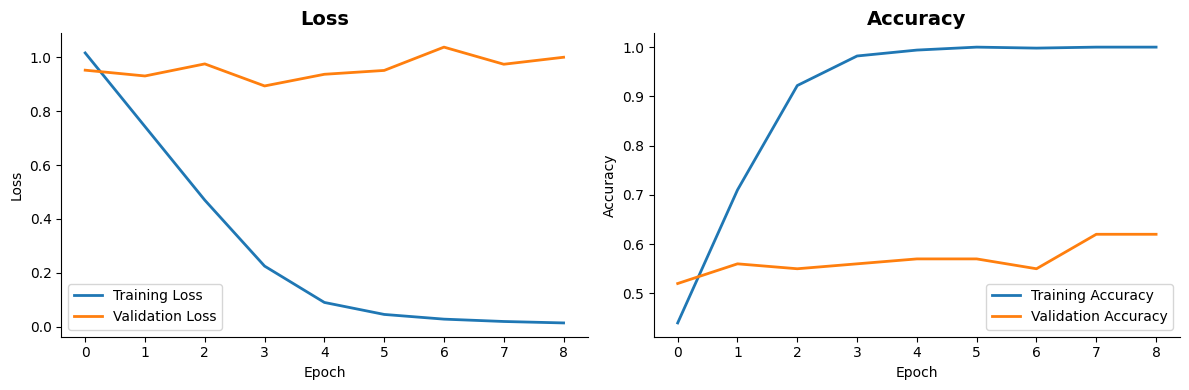

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best bidirectional RNN (config: layers_1_units_64_dir_bidirectional, F1: 0.5810) as metrics_curves_Best_bidirectional_f1.png
Hyperparameter sweep summary saved to plots\hyperparameter_sweep_summary.json
Training pipeline finished.
Training pipeline call finished. Check console output for details.


In [7]:
print("Attempting to run training pipeline...")
main_function(['--train'])
print("Training pipeline call finished. Check console output for details.")

### 7.2 Run From-Scratch Test (Specific Configuration)

This compares a Keras model with its from-scratch NumPy implementation.
**Requires:** 
- A trained Keras model (e.g., `model_layers_1_units_64_dir_unidirectional.keras`) in the `models` directory.
- `test.csv` in the `data` directory.

In [8]:
model_config_to_test = 'best_model'
print(f"Attempting to run from-scratch test for: {model_config_to_test}...")
main_function(['--test-scratch', model_config_to_test, '--inference-batch-size', '32'])
print(f"From-scratch test call for {model_config_to_test} finished. Check console output.")

Attempting to run from-scratch test for: best_model...
Starting from-scratch test for: best_model

--- Running From-Scratch Test for model: best_model ---
--- Using inference batch size for scratch model: 32 ---
Loading Keras model from: models\best_model.keras
TextVectorization layer successfully retrieved from the loaded Keras model.
Number of classes detected from Keras model's last layer: 3
Loaded 500 samples from data/train.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 100 samples from data/valid.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 400 samples from data/test.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Vectorizing test texts using the Keras model's TextVectorization layer...
Shape of vectorized test data (NumPy): (400, 120)
Loaded configuration for 'best_model' from JSON: Layers=1, Units=64, Direction=bidirectio

### 7.3 Run From-Scratch Test (Best Model with Backward Pass Demo)

Tests the `best_model.keras` and demonstrates the backward pass computation.
**Requires:**
- `best_model.keras` in the `models` directory.
- `best_model_config.json` in the `models` directory.
- `test.csv` in the `data` directory.

In [9]:
print("Attempting to run from-scratch test for 'best_model' with backward pass demo...")
main_function(['--test-scratch', 'best_model', '--demo-backward', '--inference-batch-size', '16'])
print("From-scratch test call for 'best_model' finished. Check console output.")

print("To run the best model scratch test: Uncomment AND ensure 'best_model.keras', 'best_model_config.json', and test data exist.")

Attempting to run from-scratch test for 'best_model' with backward pass demo...
Starting from-scratch test for: best_model

--- Running From-Scratch Test for model: best_model ---
--- Using inference batch size for scratch model: 16 ---
Loading Keras model from: models\best_model.keras
TextVectorization layer successfully retrieved from the loaded Keras model.
Number of classes detected from Keras model's last layer: 3
Loaded 500 samples from data/train.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 100 samples from data/valid.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 400 samples from data/test.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Vectorizing test texts using the Keras model's TextVectorization layer...
Shape of vectorized test data (NumPy): (400, 120)
Loaded configuration for 'best_model' from JSON: Layers=1, Units